In [27]:
from monodromy.depthPass import MonodromyDepth
from qiskit.transpiler.passmanager import PassManager
from qiskit.circuit.library import iSwapGate
from qiskit.transpiler.passes import Depth
from qiskit import QuantumCircuit

pm = PassManager()
pm.append(Depth())
pm.append(MonodromyDepth(basis_gate=iSwapGate().power(1/2)))

qc= QuantumCircuit(4)
qc.swap(0,1)
qc.cx(0,1)
qc.cx(1,2)
qc.swap(0,1)
qc.cx(0,1)
qc.cx(0,1)
qc.swap(2,3)
qc.cx(0,2)
qc.cx(1,2)
qc.swap(0,1)
qc.cx(2,3)
qc.cx(2,3)
display(qc.draw())

pm.run(qc)
expected_value = 14
print(f"Depth: {pm.property_set['depth']}")
print(f"Monodromy depth: {pm.property_set['monodromy_depth']}")
assert pm.property_set["monodromy_depth"] == expected_value, "Monodromy depth not calculated correctly!"


q_0: ─X───■────────X───■────■────■─────────X───────
      │ ┌─┴─┐      │ ┌─┴─┐┌─┴─┐  │         │       
q_1: ─X─┤ X ├──■───X─┤ X ├┤ X ├──┼────■────X───────
        └───┘┌─┴─┐   └───┘└───┘┌─┴─┐┌─┴─┐          
q_2: ────────┤ X ├─X───────────┤ X ├┤ X ├──■────■──
             └───┘ │           └───┘└───┘┌─┴─┐┌─┴─┐
q_3: ──────────────X─────────────────────┤ X ├┤ X ├
                                         └───┘└───┘

Depth: 10
Monodromy depth: 14


In [11]:
from monodromy.depthPass import MonodromyDepth
from qiskit.transpiler.passmanager import PassManager
from qiskit.circuit.library import CXGate
from qiskit import QuantumCircuit
pm = PassManager()
pm.append(MonodromyDepth(basis_gate=CXGate()))

qc= QuantumCircuit(3)
qc.swap(0,1)
qc.cx(0,1)
qc.cx(1,2)
qc.swap(0,1)
display(qc.draw())

pm.run(qc)

pm.property_set["monodromy_depth"]

q_0: ─X───■────────X─
      │ ┌─┴─┐      │ 
q_1: ─X─┤ X ├──■───X─
        └───┘┌─┴─┐   
q_2: ────────┤ X ├───
             └───┘

6

In [6]:
import numpy as np
from qiskit.circuit.gate import Gate
from qiskit.circuit.parameterexpression import ParameterValueType

class RiSwapGate(Gate):
    r"""RiSWAP gate.

    **Circuit Symbol:**

    .. parsed-literal::

        q_0: ─⨂─
           R(alpha)
        q_1: ─⨂─

    """

    def __init__(self, alpha: ParameterValueType):
        """Create new iSwap gate."""
        super().__init__(
            "riswap", 2, [alpha], label=r"$\sqrt[" + str(int(1 / alpha)) + r"]{iSwap}$"
        )

    def __array__(self, dtype=None):
        """Return a numpy.array for the RiSWAP gate."""
        alpha = self.params[0]
        return np.array(
            [
                [1, 0, 0, 0],
                [0, np.cos(np.pi * alpha / 2), 1j * np.sin(np.pi * alpha / 2), 0],
                [0, 1j * np.sin(np.pi * alpha / 2), np.cos(np.pi * alpha / 2), 0],
                [0, 0, 0, 1],
            ],
            dtype=dtype,
        )
    
    def inverse(self):
        #an ugly fix because I don't want to make a whole new class for this
        """Return inverse gate."""
        from qiskit.extensions import UnitaryGate
        ug = UnitaryGate(data=np.matrix(self.__array__()).getH())
        ug.latex_string = lambda gate_params: r"${iSwap^{\dag}}$"
        return ug

    @staticmethod
    def latex_string(gate_params=None):
        if gate_params is None:
            return r"$\sqrt[n]{iSwap}$"
        else:
            n = 1 / gate_params[0]
            return r"$\sqrt[" + str(int(n)) + r"]{iSwap}$"


In [9]:
from qiskit.circuit.library import RZXGate
import numpy as np

gates = [RZXGate(np.pi/3), RZXGate(np.pi/3), RZXGate(np.pi/3), RZXGate(np.pi/3)]
# gates = [RiSwapGate(1/4), RiSwapGate(1/4).inverse()]# RiSwapGate(1/3), RiSwapGate(1/4)]

from fractions import Fraction
from monodromy.coordinates import monodromy_to_positive_canonical_polytope, \
    positive_canonical_alcove_c2, unitary_to_monodromy_coordinate
from monodromy.coverage import deduce_qlr_consequences
from monodromy.static.examples import exactly, identity_polytope, \
    everything_polytope

base_iswap_fidelity = .95
def get_circuit_polytope(*basis_gate:RiSwapGate):

    circuit_polytope = identity_polytope

    for gate in basis_gate:
        b_polytope = exactly(
            *(Fraction(x).limit_denominator(10_000)
            for x in unitary_to_monodromy_coordinate(gate.to_matrix())[:-1])
        )
        circuit_polytope = deduce_qlr_consequences(
            target="c",
            a_polytope=circuit_polytope,
            b_polytope=b_polytope,
            c_polytope=everything_polytope
        )
    from monodromy.coverage import CircuitPolytope
    return CircuitPolytope(
            operations=[RiSwapGate.latex_string(basis_gate[0].params)],
            #cost=1 - (1- base_iswap_fidelity)*basis_gate.params[0],
            cost=basis_gate[0].params[0],
            convex_subpolytopes=circuit_polytope.convex_subpolytopes,
    )
    # print(monodromy_to_positive_canonical_polytope(circuit_polytope))
    # print(f"{monodromy_to_positive_canonical_polytope(circuit_polytope).volume} vs "
    #     f"{positive_canonical_alcove_c2.volume}")

In [10]:
# polytope_vertices = monodromy_to_positive_canonical_polytope(circuit_polytope).vertices
circuit_polytope = get_circuit_polytope(RiSwapGate(1/2), RiSwapGate(1/2))
reduced_vertices = monodromy_to_positive_canonical_polytope(circuit_polytope.reduce()).vertices

In [11]:
%matplotlib widget

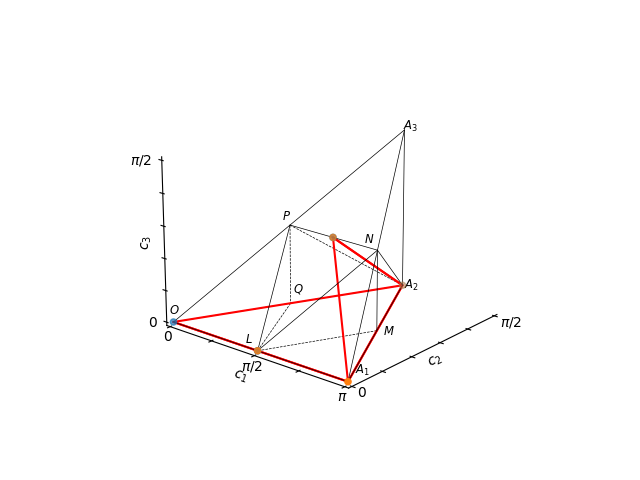

In [ ]:
import matplotlib.pyplot as plt
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

from weylchamber import WeylChamber
w = WeylChamber();

total_coord_list = []
for subpoly in reduced_vertices:
    subpoly_coords = [[float(x) for x in coord] for coord in subpoly]
    total_coord_list += subpoly_coords
    w.scatter(*zip(*subpoly_coords))

from scipy.spatial import ConvexHull
#sometimes using convexhull on the individual subpolys makes sense
#for example when they are disjointed riswap(1/4) pyramids
#but other times they should be merged like for rzx

pts = np.array(subpoly_coords)
pts = np.array(total_coord_list)
hull = ConvexHull(pts)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

w.render(ax)

In [16]:
from monodromy.coverage import *
from monodromy.haar import expected_cost
operations = []
for alpha in range(1,2):
    operations.append(get_circuit_polytope(RiSwapGate(1/alpha)))

# build the set of covering polytopes
print("==== Working to build a set of covering polytopes ====")
coverage_set = build_coverage_set(operations, chatty=True)

# print it out for user inspection 
print("==== Done. Here's what we found: ====")
print_coverage_set(coverage_set)

print("==== Haar volumes ====")
print(f"Haar-expectation cost: {expected_cost(coverage_set, chatty=True)}")


==== Working to build a set of covering polytopes ====
Considering $\sqrt[1]{iSwap}$;	Cost 1.0 and Euclidean volume   0.00%
Considering $\sqrt[1]{iSwap}$·$\sqrt[1]{iSwap}$;	Cost 2.0 and Euclidean volume   0.00%
Considering $\sqrt[1]{iSwap}$·$\sqrt[1]{iSwap}$·$\sqrt[1]{iSwap}$;	Cost 3.0 and Euclidean volume 100.00%
==== Done. Here's what we found: ====
Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 1.00	 | $\sqrt[1]{iSwap}$
  0.00% =    0/1    	 | 2.00	 | $\sqrt[1]{iSwap}$.$\sqrt[1]{iSwap}$
100.00% =    1/1    	 | 3.00	 | $\sqrt[1]{iSwap}$.$\sqrt[1]{iSwap}$.$\sqrt[1]{iSwap}$
==== Haar volumes ====
 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | $\sqrt[1]{iSwap}$
0.00000	 | $\sqrt[1]{iSwap}$.$\sqrt[1]{iSwap}$
1.00000	 | $\sqrt[1]{iSwap}$.$\sqrt[1]{iSwap}$.$\sqrt[1]{iSwap}$
Haar-expectation cost: 3.000000000000001


In [15]:
from monodromy.coverage import *
from monodromy.haar import expected_cost
operations = []
for alpha in range(2,3):
    operations.append(get_circuit_polytope(RiSwapGate(1/alpha)))

# build the set of covering polytopes
print("==== Working to build a set of covering polytopes ====")
coverage_set = build_coverage_set(operations, chatty=True)

# print it out for user inspection 
print("==== Done. Here's what we found: ====")
print_coverage_set(coverage_set)

print("==== Haar volumes ====")
print(f"Haar-expectation cost: {expected_cost(coverage_set, chatty=True)}")


==== Working to build a set of covering polytopes ====
Considering $\sqrt[2]{iSwap}$;	Cost 0.5 and Euclidean volume   0.00%
Considering $\sqrt[2]{iSwap}$·$\sqrt[2]{iSwap}$;	Cost 1.0 and Euclidean volume  50.00%
Considering $\sqrt[2]{iSwap}$·$\sqrt[2]{iSwap}$·$\sqrt[2]{iSwap}$;	Cost 1.5 and Euclidean volume 100.00%
==== Done. Here's what we found: ====
Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 0.50	 | $\sqrt[2]{iSwap}$
 50.00% =    1/2    	 | 1.00	 | $\sqrt[2]{iSwap}$.$\sqrt[2]{iSwap}$
100.00% =    1/1    	 | 1.50	 | $\sqrt[2]{iSwap}$.$\sqrt[2]{iSwap}$.$\sqrt[2]{iSwap}$
==== Haar volumes ====
 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | $\sqrt[2]{iSwap}$
0.79012	 | $\sqrt[2]{iSwap}$.$\sqrt[2]{iSwap}$
0.20988	 | $\sqrt[2]{iSwap}$.$\sqrt[2]{iSwap}$.$\sqrt[2]{iSwap}$
Haar-expectation cost: 1.1049413181578387


In [18]:
from monodromy.coverage import *
from monodromy.haar import expected_cost
operations = []
for alpha in range(3,4):
    operations.append(get_circuit_polytope(RiSwapGate(1/alpha)))

# build the set of covering polytopes
print("==== Working to build a set of covering polytopes ====")
coverage_set = build_coverage_set(operations, chatty=True)

# print it out for user inspection 
print("==== Done. Here's what we found: ====")
print_coverage_set(coverage_set)

print("==== Haar volumes ====")
print(f"Haar-expectation cost: {expected_cost(coverage_set, chatty=True)}")


==== Working to build a set of covering polytopes ====
Considering $\sqrt[3]{iSwap}$;	Cost 0.3333333333333333 and Euclidean volume   0.00%
Considering $\sqrt[3]{iSwap}$·$\sqrt[3]{iSwap}$;	Cost 0.6666666666666666 and Euclidean volume  14.81%
Considering $\sqrt[3]{iSwap}$·$\sqrt[3]{iSwap}$·$\sqrt[3]{iSwap}$;	Cost 1.0 and Euclidean volume  83.33%
Considering $\sqrt[3]{iSwap}$·$\sqrt[3]{iSwap}$·$\sqrt[3]{iSwap}$·$\sqrt[3]{iSwap}$;	Cost 1.3333333333333333 and Euclidean volume  99.38%
Considering $\sqrt[3]{iSwap}$·$\sqrt[3]{iSwap}$·$\sqrt[3]{iSwap}$·$\sqrt[3]{iSwap}$·$\sqrt[3]{iSwap}$;	Cost 1.6666666666666665 and Euclidean volume 100.00%
==== Done. Here's what we found: ====
Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 0.33	 | $\sqrt[3]{iSwap}$
 14.81% =    4/27   	 | 0.67	 | $\sqrt[3]{iSwap}$.$\sqrt[3]{iSwap}$
 83.33% =    5/6    	 | 1.00	 | $\sqrt[3]{iSwap}$.$\sqrt[3]{iSwap}$.$\sqrt[3]{iSwap}$
 99.38% =  161/162  	 | 1.33	 | $\sqr

In [19]:
from monodromy.coverage import *
from monodromy.haar import expected_cost
operations = []
for alpha in range(4,5):
    operations.append(get_circuit_polytope(RiSwapGate(1/alpha)))

# build the set of covering polytopes
print("==== Working to build a set of covering polytopes ====")
coverage_set = build_coverage_set(operations, chatty=True)

# print it out for user inspection 
print("==== Done. Here's what we found: ====")
print_coverage_set(coverage_set)

print("==== Haar volumes ====")
print(f"Haar-expectation cost: {expected_cost(coverage_set, chatty=True)}")


==== Working to build a set of covering polytopes ====
Considering $\sqrt[4]{iSwap}$;	Cost 0.25 and Euclidean volume   0.00%
Considering $\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$;	Cost 0.5 and Euclidean volume   6.25%
Considering $\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$;	Cost 0.75 and Euclidean volume  35.16%
Considering $\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$;	Cost 1.0 and Euclidean volume  83.33%
Considering $\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$;	Cost 1.25 and Euclidean volume  97.92%
Considering $\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$;	Cost 1.5 and Euclidean volume 100.00%
==== Done. Here's what we found: ====
Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 0.25	 | $\sqrt[4]{iSwap}$
  6.25% =    1/16   	 | 0.50	 | $\sqrt[4]{iSwap}$.$\sqrt[4]{iSwap}$
 35.16% =   45/128  	

In [17]:
from monodromy.coverage import *
from monodromy.haar import expected_cost
operations = []
for alpha in [2,3,4]:
    #operations.append(get_circuit_polytope(RiSwapGate(1/alpha)))
    operations.append(get_circuit_polytope(RiSwapGate(1/alpha).inverse()))

# build the set of covering polytopes
print("==== Working to build a set of covering polytopes ====")
coverage_set = build_coverage_set(operations, chatty=True)

# print it out for user inspection 
print("==== Done. Here's what we found: ====")
print_coverage_set(coverage_set)

print("==== Haar volumes ====")
print(f"Haar-expectation cost: {expected_cost(coverage_set, chatty=True)}")


==== Working to build a set of covering polytopes ====


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [20]:
from monodromy.coverage import *
from monodromy.haar import expected_cost
operations = []
for alpha in range(10,11):
    operations.append(get_circuit_polytope(RiSwapGate(1/alpha)))

# build the set of covering polytopes
print("==== Working to build a set of covering polytopes ====")
coverage_set = build_coverage_set(operations, chatty=True)

# print it out for user inspection 
print("==== Done. Here's what we found: ====")
print_coverage_set(coverage_set)

print("==== Haar volumes ====")
print(f"Haar-expectation cost: {expected_cost(coverage_set, chatty=True)}")


==== Working to build a set of covering polytopes ====
Considering $\sqrt[10]{iSwap}$;	Cost 0.1 and Euclidean volume   0.00%
Considering $\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$;	Cost 0.2 and Euclidean volume   0.40%
Considering $\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$;	Cost 0.30000000000000004 and Euclidean volume   2.25%
Considering $\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$;	Cost 0.4 and Euclidean volume   5.33%
Considering $\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$;	Cost 0.5 and Euclidean volume  10.42%
Considering $\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$;	Cost 0.6 and Euclidean volume  18.00%
Considering $\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$·$\sqrt[10]{iSwap}$;	Cost 0.7 and Euclidean volume  28.58%
Considering $\sqrt[10]{iSwap}$·$\sqrt[10

In [14]:
from monodromy.coverage import *
from monodromy.haar import expected_cost
operations = []
for alpha in range(1,6):
    operations.append(get_circuit_polytope(RiSwapGate(1/alpha)))

# build the set of covering polytopes
print("==== Working to build a set of covering polytopes ====")
coverage_set = build_coverage_set(operations, chatty=True)

# print it out for user inspection 
print("==== Done. Here's what we found: ====")
print_coverage_set(coverage_set)

print("==== Haar volumes ====")
print(f"Haar-expectation cost: {expected_cost(coverage_set, chatty=True)}")


==== Working to build a set of covering polytopes ====
Considering $\sqrt[5]{iSwap}$;	Cost 0.2 and Euclidean volume   0.00%
Considering $\sqrt[4]{iSwap}$;	Cost 0.25 and Euclidean volume   0.00%
Considering $\sqrt[3]{iSwap}$;	Cost 0.3333333333333333 and Euclidean volume   0.00%
Considering $\sqrt[5]{iSwap}$·$\sqrt[5]{iSwap}$;	Cost 0.4 and Euclidean volume   3.20%
Considering $\sqrt[4]{iSwap}$·$\sqrt[5]{iSwap}$;	Cost 0.45 and Euclidean volume   4.12%
Considering $\sqrt[5]{iSwap}$·$\sqrt[4]{iSwap}$;	Cost 0.45 and Euclidean volume   4.12%
Considering $\sqrt[2]{iSwap}$;	Cost 0.5 and Euclidean volume   0.00%
Considering $\sqrt[4]{iSwap}$·$\sqrt[4]{iSwap}$;	Cost 0.5 and Euclidean volume   6.25%
Considering $\sqrt[5]{iSwap}$·$\sqrt[3]{iSwap}$;	Cost 0.5333333333333333 and Euclidean volume   4.74%
Considering $\sqrt[3]{iSwap}$·$\sqrt[5]{iSwap}$;	Cost 0.5333333333333333 and Euclidean volume   4.74%
Considering $\sqrt[3]{iSwap}$·$\sqrt[4]{iSwap}$;	Cost 0.5833333333333333 and Euclidean volume   8.4